### Import libraries 

In [1]:
# Load libraries
import nltk
import random
import re
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from docx import Document



### Download  NLTK data (One time)

In [2]:
# Download  NLTK data (Remove # sign from the following lines to run)
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt_tab')
#nltk.download('averaged_perceptron_tagger_eng')

### Customize

In [3]:
# Customize parameters

my_case_report="0908 Compliance_Case_Report.docx"
my_csv_report="0908 Compliance_Case_Report.csv"
my_risk_level_plot="0908 risk_level_distribution.png"
my_message_source_plot="0908 source_distribution.png"
my_entity_plot="0908 entity_frequency_chart.png"


my_flagged_messages=[
    "Transaction was processed without notifying the compliance officer.",
    "Audit report was completed and emailed to the external auditor.",
    "The request was executed while the internal review was still pending.",
    "Policy update was approved by Director John Smith on March 5th.",
    "Customer complaint was not logged due to verbal communication.",
    "All cash deposits above threshold were reported as required.",
    "Account access was granted to an unauthorized third party.",
    "Client data backup was delayed without proper documentation.",
    "Risk control policy was acknowledged and filed.",
    "Funds were transferred after hours with no approval."
]

# Metadata for each message
sources = ["Email", "Chat", "Log", "Memo", "Email", "Log", "Chat", "Email", "Log", "Chat"]
ml_predictions = [1, 0, 1, 0, 1, 0, 1, 1, 0, 1]
ml_confidences = [0.92, 0.15, 0.87, 0.20, 0.90, 0.05, 0.95, 0.89, 0.08, 0.93]
rule_triggers = [True, False, True, False, True, False, True, True, False, True]


### Load model and data

In [4]:
# Load Flagged Messages
flagged_messages = my_flagged_messages

start_time = datetime.now() - timedelta(days=10)
timestamps = [start_time + timedelta(hours=i * 6) for i in range(len(flagged_messages))]

### Helper Functions

In [5]:
# Create helper function

def preprocess(text):
    """Preprocess message text for vectorization."""
    tokens = word_tokenize(text.lower())
    words = [w for w in tokens if w.isalpha()]
    stop_words = set(stopwords.words('english'))
    filtered = [w for w in words if w not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(w) for w in filtered]
    return ' '.join(lemmas)

def extract_entities(text):
    """Basic entity extraction using regex and POS tagging."""
    # Common patterns
    dates = re.findall(r'\b(?:\d{1,2}[/-])?(?:\d{1,2}[/-])?\d{2,4}\b', text)
    emails = re.findall(r'\S+@\S+', text)
    capitalized_words = [word for word, tag in pos_tag(word_tokenize(text)) if tag == 'NNP']
    
    entities = []
    entities += [(d, 'DATE') for d in dates]
    entities += [(e, 'EMAIL') for e in emails]
    entities += [(w, 'PROPER_NOUN') for w in capitalized_words]
    
    return entities

def assign_risk(rule_triggered, ml_pred, ml_conf):
    """Assign risk tier based on rule/ML combination."""
    if rule_triggered and ml_pred == 1:
        return "High"
    elif ml_pred == 1 and ml_conf > 0.8:
        return "Medium"
    elif rule_triggered:
        return "Low"
    else:
        return "None"

def recommend_action(risk):
    """Recommend an action based on risk tier."""
    return {
        "High": "Immediate Review",
        "Medium": "Manager Review",
        "Low": "Log and Monitor",
        "None": "Archive"
    }[risk]

def random_status(risk):
    """Randomly simulate current case status."""
    return random.choice(["Pending", "Escalated"] if risk in ["High", "Medium"] else ["Reviewed", "Closed"])


### Analyze and Generate Reports

In [6]:
# Initialize Word document and Excel data container
doc = Document()
doc.add_heading("Compliance Monitoring Case Report", 0)

excel_rows = []
risk_counts = {"High": 0, "Medium": 0, "Low": 0, "None": 0}
source_counts = {}
entity_counter = {}

print("\n CASE SUMMARY\n")

for i, msg in enumerate(flagged_messages):
    # Extract core metadata
    source = sources[i]
    timestamp = timestamps[i].strftime('%Y-%m-%d %H:%M:%S')
    rule_triggered = rule_triggers[i]
    ml_pred = ml_predictions[i]
    ml_conf = ml_confidences[i]

    # Derive decision data
    risk = assign_risk(rule_triggered, ml_pred, ml_conf)
    action = recommend_action(risk)
    status = random_status(risk)

    rationale = []
    if rule_triggered:
        rationale.append("Rule-based flag")
    if ml_pred == 1:
        rationale.append(f"ML flagged with {ml_conf:.2f} confidence")

    ents = extract_entities(msg)
    ent_text = ", ".join([f"{e[0]} ({e[1]})" for e in ents]) if ents else "None"
    for ent in ents:
        entity_counter[ent[0]] = entity_counter.get(ent[0], 0) + 1

    # Tally for visualization
    risk_counts[risk] += 1
    source_counts[source] = source_counts.get(source, 0) + 1

    # Print summary
    print(f"Case {i+1}: Risk = {risk}, Action = {action}, Status = {status}")

    # 📤 Add to Word Report
    doc.add_heading(f"Case {i+1}", level=1)
    doc.add_paragraph(f"Message: {msg}")
    doc.add_paragraph(f"Source: {source}")
    doc.add_paragraph(f"Timestamp: {timestamp}")
    doc.add_paragraph(f"Risk Level: {risk}")
    doc.add_paragraph(f"Recommended Action: {action}")
    doc.add_paragraph(f"Case Status: {status}")
    doc.add_paragraph("Rationale: " + "; ".join(rationale))
    doc.add_paragraph("Named Entities: " + ent_text)
    doc.add_paragraph("")

    # 📤 Add to Excel
    excel_rows.append({
        "Case ID": i + 1,
        "Message": msg,
        "Source": source,
        "Timestamp": timestamp,
        "Risk Level": risk,
        "Action": action,
        "Status": status,
        "Rationale": "; ".join(rationale),
        "Entities": ent_text
    })



 CASE SUMMARY

Case 1: Risk = High, Action = Immediate Review, Status = Escalated
Case 2: Risk = None, Action = Archive, Status = Closed
Case 3: Risk = High, Action = Immediate Review, Status = Pending
Case 4: Risk = None, Action = Archive, Status = Closed
Case 5: Risk = High, Action = Immediate Review, Status = Escalated
Case 6: Risk = None, Action = Archive, Status = Reviewed
Case 7: Risk = High, Action = Immediate Review, Status = Escalated
Case 8: Risk = High, Action = Immediate Review, Status = Pending
Case 9: Risk = None, Action = Archive, Status = Closed
Case 10: Risk = High, Action = Immediate Review, Status = Pending


### Generate and save reports and visualizations

Word report saved as 0908 Compliance_Case_Report.docx
 CSV report saved as 0908 Compliance_Case_Report.csv


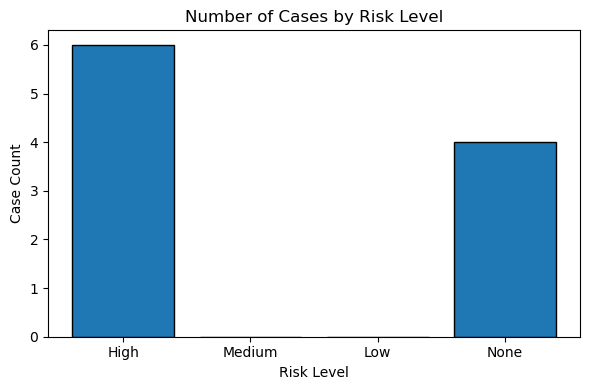

Saved chart: 0908 risk_level_distribution.png


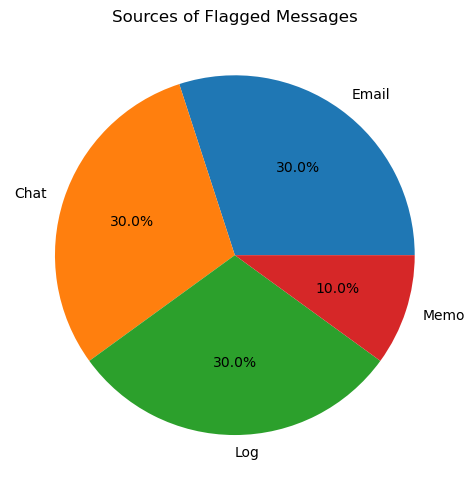

Saved chart: 0908 source_distribution.png


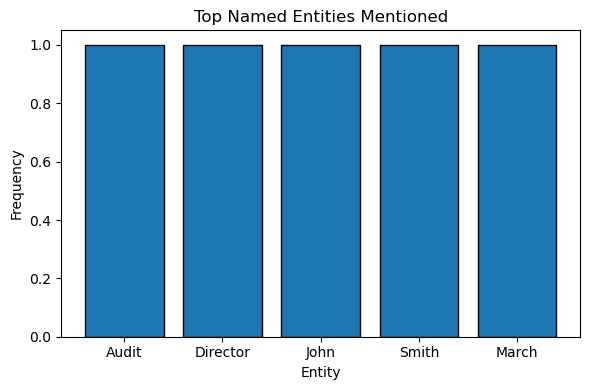

Saved chart: 0908 entity_frequency_chart.png


In [7]:
# Save Word report
doc.save(my_case_report)
print(f"Word report saved as {my_case_report}")

# Save CSV report
df = pd.DataFrame(excel_rows)
df.to_csv(my_csv_report, index=False)
print(f" CSV report saved as {my_csv_report}")


# Chart 1: Risk distribution
plt.figure(figsize=(6,4))
plt.bar(risk_counts.keys(), risk_counts.values(), edgecolor='black')
plt.title("Number of Cases by Risk Level")
plt.xlabel("Risk Level")
plt.ylabel("Case Count")
plt.tight_layout()
plt.savefig(my_risk_level_plot)
plt.show()
plt.close()
print(f"Saved chart: {my_risk_level_plot}")

# Chart 2: Message source pie chart
plt.figure(figsize=(5,5))
plt.pie(source_counts.values(), labels=source_counts.keys(), autopct='%1.1f%%')
plt.title("Sources of Flagged Messages")
plt.tight_layout()
plt.savefig(my_message_source_plot)
plt.show()
plt.close()
print(f"Saved chart: {my_message_source_plot}")

# Chart 3: Named entity frequency
top_entities = dict(sorted(entity_counter.items(), key=lambda x: x[1], reverse=True)[:5])
if top_entities:
    plt.figure(figsize=(6,4))
    plt.bar(top_entities.keys(), top_entities.values(), edgecolor='black')
    plt.title("Top Named Entities Mentioned")
    plt.xlabel("Entity")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(my_entity_plot)
    plt.show()
    plt.close()
    print(f"Saved chart: {my_entity_plot}")

